the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60174.979820 from DATE-END'. [astropy.wcs.wcs]


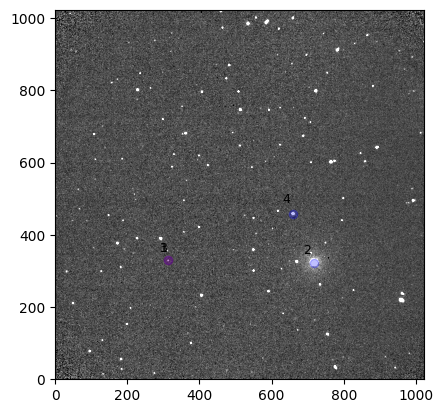

In [26]:
import os
import pandas as pd
from photometry import Photometry
from scripts.tools import sort_files
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from photometry import Photometry

star_name = "GRB 230818A"
experiment = "first rotor position"
_set = "first"
camera = 4
max_box_size = 20
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    experiment,
    star_name,
    f"{_set} set",
)

GOOD_IMAGE = {
    "first_cam3": "3_e_20230818_5_1_1_1.fits",
    "second_cam3": "3_e_20230818_6_1_1_1.fits",
    "first_cam4": "4_e_20230818_5_1_1_1.fits",
    "second_cam4": "4_e_20230818_6_1_1_1.fits",
}
file = os.path.join(src_path, GOOD_IMAGE[f"{_set}_cam{camera}"])
image = fits.getdata(file)
median = np.median(image)
std = np.median(np.abs(image - median))
plt.imshow(
    image, vmax=median + 7 * std, vmin=median - 3 * std, origin="lower", cmap="gray"
)

csv_file = os.path.join(src_path, "..", f"objects coordinates.csv")
df = pd.read_csv(csv_file)
objects = {
    "name": df["name"],
    "ra": df[f"ra_{_set}_set_cam{camera}"],
    "dec": df[f"dec_{_set}_set_cam{camera}"],
}
objects = pd.DataFrame.from_dict(objects)
phot = Photometry(file, objects, max_box_size)
phot.reset_object_coords()
for idx, _object in enumerate(phot.obj_list):
    name, x, y, *_ = _object.get_info()
    color = "b"
    if name == "original":
        color = "r"
    plt.plot(x, y, f"{color}o", alpha=0.25)
    plt.annotate(f"{idx+1}", (x * 0.99, y * 1.05), ha="right", va="bottom", fontsize=9)

plt.show()

# Create photometry.csv

In [27]:
objects_photometry = {}
for obj_name in objects["name"]:
    objects_photometry[obj_name] = dict.fromkeys(
        ("mjd", "xcoord", "ycoord", "psf_radius", "star_photons"), _value=[]
    )


image_list = sort_files(src_path, f"{camera}_e")
for file in image_list:
    file_path = os.path.join(src_path, file)

    phot = Photometry(file_path, objects, max_box_size)
    phot.reset_object_coords()
    phot.calc_psf_radius()
    phot.calc_sky_photons()
    phot.calc_psf_photons()
    mjd = phot.get_mjd()

    for _object in phot.obj_list:
        name, xcoord, ycoord, *_, star_photons = _object.get_info()
        objects_photometry[name]["mjd"].append(mjd)
        objects_photometry[name]["xcoord"].append(xcoord)
        objects_photometry[name]["ycoord"].append(ycoord)
        objects_photometry[name]["star_photons"].append(star_photons)

for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(
        src_path, "..", "..", "csv", f"{_set} set", f"{obj_name}_cam{camera}.csv"
    )
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

Set MJD-END to 60174.980746 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.981672 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.982598 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.984450 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.985376 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.987228 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.989080 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.990005 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.991857 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.992783 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.996487 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.997413 from DATE-END'. [astropy.wcs.wcs]


# Plot light curve

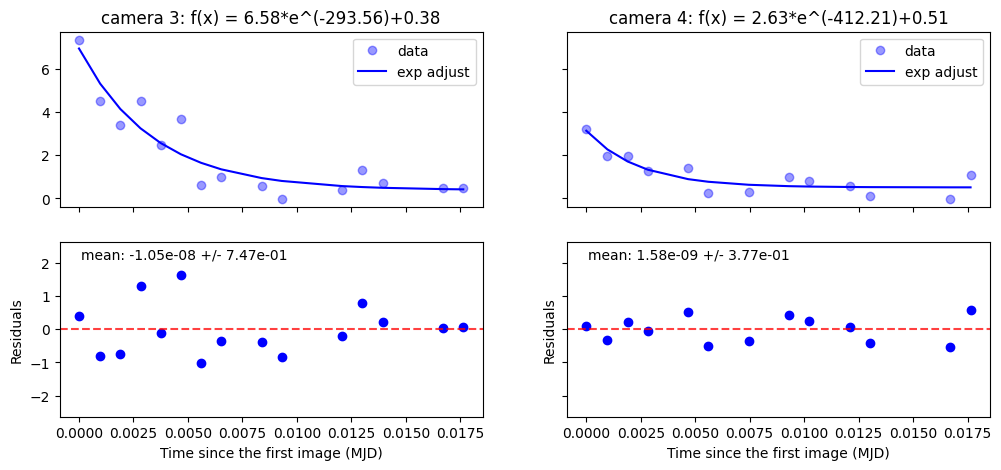

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy

star_name = "GRB 230818A"
experiment = "first rotor position"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)


def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b


csv_path = os.path.join(src_path, "csv")
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharey="row", sharex="col")
for camera in [3, 4]:
    cand, comp_1, comp_2 = [], [], []
    for _set in ["first"]:
        csv_file = os.path.join(
            csv_path, f"{_set} set", f"comparison_1_cam{camera}.csv"
        )
        comp_1.append(pd.read_csv(csv_file))
        csv_file = os.path.join(csv_path, f"{_set} set", f"candidate_1_cam{camera}.csv")
        cand.append(pd.read_csv(csv_file))
        csv_file = os.path.join(
            csv_path, f"{_set} set", f"comparison_2_cam{camera}.csv"
        )
        comp_2.append(pd.read_csv(csv_file))

    df = pd.concat(cand, axis=0, ignore_index=True)
    cand = df["star_photons"]
    df = pd.concat(comp_1, axis=0, ignore_index=True)
    comp_1 = df["star_photons"]
    df = pd.concat(comp_2, axis=0, ignore_index=True)
    comp_2 = df["star_photons"]
    comp = comp_1
    cand /= comp
    median = np.median(cand)
    cand /= median
    mjd = df["mjd"]
    mjd -= mjd[0]

    ax = axs[0, camera - 3]
    ax.plot(mjd, cand, "bo", alpha=0.4, label="data")

    params, cv = scipy.optimize.curve_fit(monoExp, mjd, cand)
    m, t, b = params
    exp_adjust = monoExp(mjd, m, t, b)
    ax.plot(mjd, exp_adjust, "b-", label="exp adjust")
    ax.set_title(f"camera {camera}: f(x) = {m:.2f}*e^({-t:.2f})+{b:.2f}")
    ax.legend()

    ax = axs[1, camera - 3]
    residuals = cand - exp_adjust
    mean = np.mean(residuals)
    std = np.std(residuals)
    ax.plot(mjd, residuals, "ob")
    ax.set_ylabel("Residuals")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    # ax.axhline(mean-3*std, color="r", linestyle="--", alpha=0.75)
    # ax.axhline(mean+3*std, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - 7 * std, mean + 7 * std)
    ax.set_xlabel("Time since the first image (MJD)")
    ax.annotate(
        f"mean: {mean:.2e} +/- {std:.2e}",
        (0.05, 0.9),
        fontsize=10,
        ha="left",
        xycoords="axes fraction",
    )

plt.savefig(os.path.join(src_path, "light_curve.png"))
plt.show()

# Plot object coordinates over the image

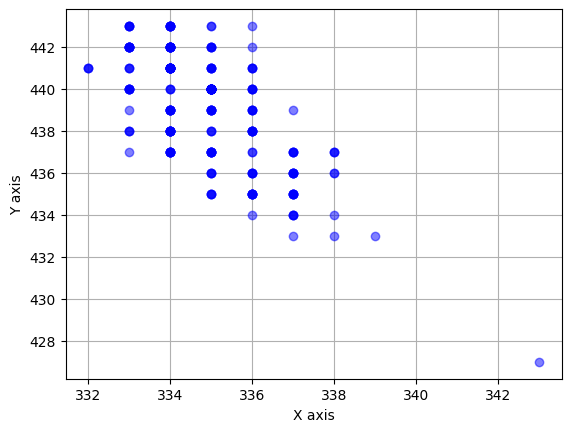

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import os

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)

csv_file = os.path.join(src_path, "csv", "first set", "candidate_1_cam3.csv")
df = pd.read_csv(csv_file)
plt.plot(df["xcoord"], df["ycoord"], "bo", alpha=0.5)
# plt.xlim(0, 1024)
# plt.ylim(0, 1024)
plt.xlabel(("X axis"))
plt.ylabel("Y axis")
plt.grid()
plt.show()